<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/Simple_PCA_Conceptnet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import gensim.downloader as gs
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from functools import reduce
from scipy import stats
from scipy.special import softmax
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch import nn

In [44]:
# For Wordnet

import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [45]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('whaleloops/phrase-bert')
embed_length = len(model.encode("raymond"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/670 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [46]:
# Methods to calculate valence and concreteness of a sense

def calc_valence(sense: str):
  s = sense.lower()
  phrases = re.split('/|,', s)
  total_valence = 0
  valence_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    # This line removes all parts between parentheses:
    # p = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", p)
    try:
      valence = df_valence[df_valence['Word']==p]['V.Mean.Sum'].values[0]
      if not np.isnan(valence):
        total_valence += valence
        valence_data += 1
    except:
      pass
  if valence_data == 0:
    total_valence = np.nan
  else:
    total_valence /= valence_data
  return total_valence

def calc_concrete(sense: str):
  s = sense.lower()
  phrases = re.split('/|,', s)
  total_conc = 0
  conc_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    # This line removes all parts between parentheses:
    # p = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", p)
    try:
      conc = df_concrete[df_concrete['Word']==p]['Conc.M'].values[0]
      if not np.isnan(conc):
        total_conc += conc
        conc_data += 1
    except:
      pass
  if conc_data == 0:
    total_conc = np.nan
  else:
    total_conc /= conc_data
  return total_conc

df_concrete = pd.read_csv('drive/MyDrive/FURSP/brysbaert_concreteness.csv') # Word, Conc.M
df_valence = pd.read_csv('drive/MyDrive/FURSP/Ratings_Warriner_et_al.csv') # Word, V.Mean.Sum [or A for arousal, D for dominance]

In [47]:
datSemShift = pd.read_csv("drive/MyDrive/FURSP/datasemshift.csv")

datSemShift = datSemShift[(datSemShift['gendirection'] == '→')]
datSemShift = datSemShift[(datSemShift['type'] == ' Semantic evolution') | (datSemShift['type'] == ' Polysemy')]
datSemShift = datSemShift[(datSemShift['language1'] == datSemShift['language2'])]
datSemShift = datSemShift[(datSemShift['lexeme1'] == datSemShift['lexeme2'])]
datSemShift = datSemShift[~datSemShift['meaning1'].str.contains('<')]
datSemShift = datSemShift[~datSemShift['meaning2'].str.contains('<')]
datSemShift = datSemShift[(datSemShift['status']!='Suspended') & (datSemShift['status']!='Rejected')]

# Nope, plot twist! Using the cleaned data instead
datSemShift = pd.read_csv("drive/MyDrive/FURSP/cleaned_dat_sem_shift.csv")
datSemShift.drop(datSemShift.columns[[0, 1, 2]], axis=1, inplace=True)
datSemShift.rename(columns={"meaning1_clean": "meaning1", "meaning2_clean": "meaning2"}, inplace=True)

df = pd.DataFrame(datSemShift)
df.shape

(2941, 2)

In [48]:
# list of senses
# note that this may include senses without embeddings (i.e. that are ignored by the database)
senses = list(pd.concat([df['meaning1'], df['meaning2']]).unique())

embeddings = model.encode(senses)
embed_dict = {}
for sense, embedding in zip(senses, embeddings):
  embed_dict[sense] = embedding
del embed_dict[np.nan]

In [49]:
# list of pairs (meaning1, meaning2) that have an embedding
meaning_pairs = [(row['meaning1'], row['meaning2']) for i, row in df.iterrows() if row['meaning1'] in embed_dict and row['meaning2'] in embed_dict]

# Dictionary of i -> [component i of every sense embedding of meaning1, in the order of senses in meaning_pairs]
m1_dict = {i : [embed_dict[m1][i] for m1, m2 in meaning_pairs] for i in range(embed_length)} 

# Dictionary of i -> [component i of every sense embedding of meaning2, in the order of senses in meaning_pairs]
m2_dict = {i : [embed_dict[m2][i] for m1, m2 in meaning_pairs] for i in range(embed_length)} 

m1_df = pd.DataFrame.from_dict(m1_dict)
m2_df = pd.DataFrame.from_dict(m2_dict)
dif_df = m2_df - m1_df

#
# Here: we choose how we want to combine the 2 dataframes, either through concatenation or difference
#
df_embeds = dif_df
#df_embeds = pd.concat([m1_df, m2_df, dif_df], axis=1)

PCA time!
---

In [50]:
num_comps = 100
pca = PCA(n_components=num_comps)
principal_components = pca.fit_transform(df_embeds)
#print(pca.explained_variance_ratio_)
principal_df = pd.DataFrame(data = principal_components, 
                           columns = ['PC' + str(i) for i in range(1, num_comps+1)])
principal_df.shape

(2939, 100)

In [51]:
# Sorted arrays of the senses/sense pairs that are lowest/highest for each embedding dimension
pca_compnum_to_sorted = [sorted([(principal_df.iloc[i]['PC' + str(comp)], meaning_pairs[i][0], meaning_pairs[i][1]) for i in range(len(meaning_pairs))]) for comp in range(1, num_comps+1)] 

In [52]:
i = 0

print(*pca_compnum_to_sorted[i][:-30:-1], sep='\n')
print()
print(*pca_compnum_to_sorted[i][:30], sep='\n')

(11.612685, 'blind', 'solid or entire or continuous')
(10.805483, 'daughter', 'Aloe vera plant')
(10.792109, 'woman', 'sheaf')
(10.516839, 'woman', 'Aloe vera plant')
(9.989091, 'stepson', 'sucker botany')
(9.610381, 'forehead', 'salient part or ledge')
(9.164037, 'father', 'beginning')
(9.074038, 'cat', 'anchor')
(8.86268, 'to feel pity', 'to spare or to economize')
(8.839708, 'to die', 'to abate about wind')
(8.731146, 'grandmother', 'mandrel technology')
(8.565102, 'to sit down', 'to shrink of textile')
(8.547482, 'face', 'surface')
(8.4272585, 'saw', 'mountain ridge or edge')
(8.303538, 'bitter', 'freshwater fish')
(8.289205, 'man', 'main')
(8.269545, 'to kill', 'to extinguish')
(8.231903, 'face', 'mountain slope')
(8.169542, 'mother', 'main')
(8.110116, 'head', 'ear or spike of a grain plant')
(8.0039015, 'shame', 'genitalia')
(7.99559, 'drunk', 'great bilberry  ')
(7.967397, 'to practice witchcraft', 'to make or create')
(7.861537, 'tooth', 'salient part or ledge')
(7.849487, 'be

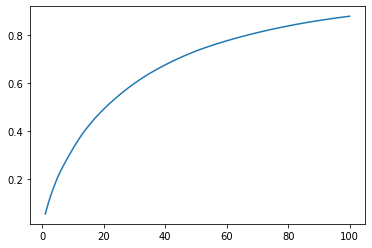

In [53]:
plt.plot(range(1, num_comps+1), pca.explained_variance_ratio_.cumsum())

Find Spearman correlation between each principle component and valence/concreteness differences:

In [54]:
# Create dictionaries of sense -> valence and sense -> concreteness

senses_dss = list(embed_dict.keys())
valence_dict_dss = {}
concrete_dict_dss = {}
for i in range(len(senses_dss)):
  valence_dict_dss[senses_dss[i]] = calc_valence(senses_dss[i])
  concrete_dict_dss[senses_dss[i]] = calc_concrete(senses_dss[i])
  
def get_valence_dss(sense: str):
  return valence_dict_dss[sense]

def get_concrete_dss(sense: str):
  return concrete_dict_dss[sense]

def get_valence_dif_dss(sense1: str, sense2: str):
  return get_valence_dss(sense2) - get_valence_dss(sense1) 

def get_concrete_dif_dss(sense1: str, sense2: str):
  return get_concrete_dss(sense2) - get_concrete_dss(sense1)

def create_graph_vals_dss(relation: str):
  if relation == "orientation":
    principal_df["valence_dif"] = principal_df.apply(lambda x : get_valence_dif_dss(x['index'], x['meaning2']) , axis=1)
  elif relation == "metaphoricity":
    principal_df["concrete_dif"] = principal_df.apply(lambda x : get_concrete_dif_dss(x['meaning1'], x['meaning2']) , axis=1)

In [55]:
principal_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,1.338911,0.921965,2.200855,0.246891,-7.774201,-2.851806,0.201436,3.916951,4.141418,1.323899,...,-0.620686,-0.151965,0.320865,0.246042,-0.842537,-0.101009,-0.261349,0.240129,-0.481526,-0.159290
1,4.469817,-0.069953,-1.954937,-3.604832,-6.184784,-1.829093,-1.171380,2.697797,3.814236,1.232715,...,-0.568021,-0.221093,0.055235,0.774911,-0.520411,0.157261,-0.758151,0.121738,-0.129401,-0.454089
2,5.068177,-5.101311,-0.056647,1.202679,1.589254,0.172072,-3.745970,-0.477982,2.133062,0.645378,...,-0.226599,0.097152,1.309568,0.053761,1.297310,-0.210613,0.653946,-0.200429,-2.097932,-0.998377
3,-0.055857,-1.480901,6.630886,0.363871,1.878217,2.874652,0.503528,2.551828,0.077928,-1.472401,...,1.018973,0.055382,0.461220,-0.139587,-0.122049,-0.170044,0.075222,-0.262699,0.426047,-0.058189
4,-3.205110,-2.393625,0.809444,1.384980,0.671431,-0.834802,0.776778,2.557414,0.635485,3.964399,...,-0.886963,-0.251039,0.651529,-0.608378,-0.606025,0.321459,-1.164607,-0.494997,-1.540467,-0.500938


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0.0569347844868018, -0.10551848634957128, -0.2874014708495086, -0.0743892010387202, -0.35159017546079624, 0.03253034664980471, -0.038686469451743054, 0.21355600617513215, -0.15303179989606086, 0.2536722016659442, -0.0028561314655180556, -0.022161475629531135, -0.05910679301578809, 0.07718567309431218, -0.06420141502345843, 0.12864238155269928, -0.23360077961359726, 0.001787933637394912, 0.03210446412915733, -0.1858940264298486, 0.07737307144894784, 0.022746670819084228, -0.19531742276739417, -0.0880614467927263, -0.06814302405966123, -0.05781536072582747, -0.00028654235999920404, 0.04962648584262782

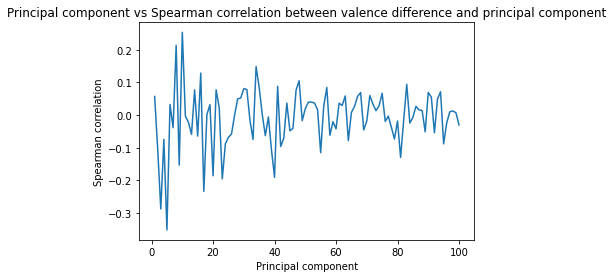

In [56]:
valence_df = pd.DataFrame(principal_df)
valence_df['valence_dif'] = valence_df.index
valence_df["valence_dif"] = valence_df.apply(lambda x : get_valence_dif_dss(meaning_pairs[int(x['valence_dif'])][0], meaning_pairs[int(x['valence_dif'])][1]) , axis=1)
valence_df.dropna(inplace=True)

x = []
y = []

for i in range(1, num_comps+1):
  corr = stats.spearmanr(valence_df["valence_dif"], valence_df[f"PC{i}"])
  x.append(i)
  y.append(corr[0])

print(x)
print(y)

plt.plot(x, y)
plt.title("Principal component vs Spearman correlation between valence difference and principal component")
plt.xlabel("Principal component")
plt.ylabel("Spearman correlation")
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0.21078070784189146, -0.3918697307545052, 0.31265909689058385, 0.08597181059882217, 0.17324862454621107, 0.09904298553343227, -0.031942370972327716, 0.14592281541490038, -0.04387751319217854, 0.13136088490421682, 0.3854816050685327, 0.025442631592480884, 0.07656159841446893, -0.10882242776998327, 0.042090868307013675, -0.07516943295183838, 0.04743961290065455, -0.05807849247691386, -0.021714073590538577, 0.13792424457944338, 0.08892820534572018, -0.08373981664783675, -0.03760832827622841, -0.038398133898960796, -0.18382512250185493, -0.09035810490060542, 0.06751056692094881, -0.08334605103787845, -0

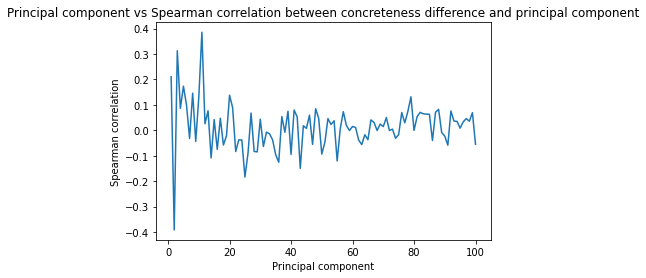

In [57]:
concrete_df = pd.DataFrame(principal_df)
concrete_df['concrete_dif'] = concrete_df.index
concrete_df["concrete_dif"] = concrete_df.apply(lambda x : get_concrete_dif_dss(meaning_pairs[int(x['concrete_dif'])][0], meaning_pairs[int(x['concrete_dif'])][1]) , axis=1)
concrete_df.dropna(inplace=True)

x = []
y = []

for i in range(1, num_comps+1):
  corr = stats.spearmanr(concrete_df["concrete_dif"], concrete_df[f"PC{i}"])
  x.append(i)
  y.append(corr[0])

print(x)
print(y)

plt.plot(x, y)
plt.title("Principal component vs Spearman correlation between concreteness difference and principal component")
plt.xlabel("Principal component")
plt.ylabel("Spearman correlation")
plt.show()

Interpret PCA graphs
---

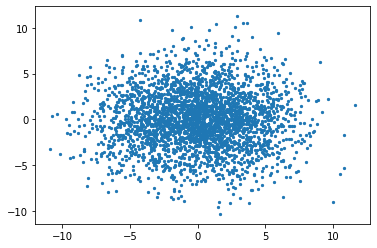

In [58]:
# First: try using PCA
n=4
pca_2d = PCA(n_components=n)
components_2d = pca_2d.fit_transform(df_embeds)
pc_df = pd.DataFrame(data = components_2d, 
                           columns = ['PC' + str(i) for i in range(1, n+1)])

plt.scatter(pc_df['PC1'], pc_df['PC2'], s=5)
plt.show()

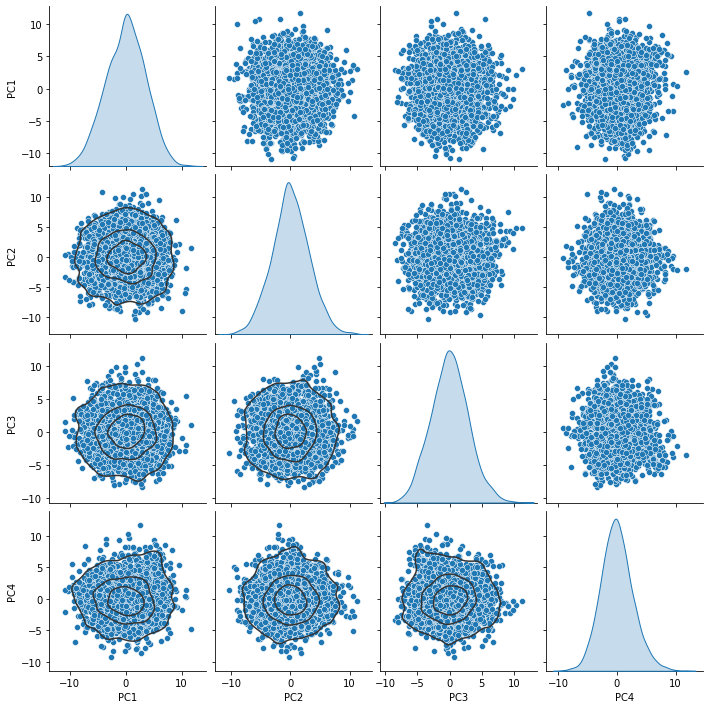

In [59]:
g = sns.pairplot(pc_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

(1000, 2304)


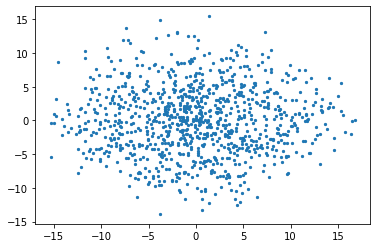

In [60]:
import random
random.seed(24)
sample_size = 1000

# Try PCA analysis on randomly taken source + target words, just to make sure that it's not a fluke

sources = random.sample(list(embed_dict), sample_size)
targets = random.sample(list(embed_dict), sample_size)

# Dictionary of i -> [component i of every sense embedding of source dict, in the order of senses in meaning_pairs]
sources_dict = {i : [embed_dict[s][i] for s in sources] for i in range(embed_length)} 

# Dictionary of i -> [component i of every sense embedding of meaning2, in the order of senses in meaning_pairs]
targets_dict = {i : [embed_dict[t][i] for t in targets] for i in range(embed_length)} 

sources_df = pd.DataFrame.from_dict(sources_dict)
targets_df = pd.DataFrame.from_dict(targets_dict)
random_dif_df = targets_df - sources_df

#
# Here: we choose how we want to combine the 2 dataframes, either through concatenation or difference
# Right now: we are chosing difference 
#
random_embeds = pd.concat([ sources_df, targets_df, random_dif_df ], axis=1)
#df_embeds = m2_df - m1_df
print(random_embeds.shape)

n=3
random_pca = PCA(n_components=n)
random_components = random_pca.fit_transform(random_embeds)
random_pc_df = pd.DataFrame(data = random_components, 
                           columns = ['PC' + str(i) for i in range(1, n+1)])

plt.scatter(random_pc_df['PC1'], random_pc_df['PC2'], s=5)
plt.show()

In [61]:
# Test what are the meaning pairs and coordinates of different "clusters" are

[(meaning_pairs[i], pc_df['PC1'][i], pc_df['PC2'][i]) for i in pc_df[(pc_df['PC1'] < -0.25) & (pc_df['PC2'] < -0.35)].index.tolist()]

[(('Easter', 'ladybird'), -3.2048042, -2.3975887),
 (('act or deed', 'drama theater'), -1.7095754, -7.8337445),
 (('active', 'clever'), -4.743843, -5.5223093),
 (('active', 'keen of senses'), -2.710814, -6.5011187),
 (('ahead', 'elder'), -2.525332, -5.6091986),
 (('alone', 'god'), -0.3884484, -3.9682624),
 (('any', 'bad'), -3.5651937, -5.272202),
 (('arc', 'bow weapon'), -1.6755202, -1.9718449),
 (('arc', 'rainbow'), -1.9946287, -8.519),
 (('attentive', 'sober'), -2.1515436, -5.15675),
 (('back body part', 'book back'), -1.7198501, -0.6489444),
 (('back body part', 'height of a person'), -2.5008738, -1.8970939),
 (('back body part', 'loins'), -1.6342707, -5.1015973),
 (('barrel', 'penny bun fungus'), -0.98840624, -4.2536716),
 (('barrier', 'diaphragm'), -3.061094, -5.0720835),
 (('bead', 'cataract of the eye'), -2.8802626, -0.4859495),
 (('bear ', 'hedgehog '), -0.5592888, -5.557941),
 (('before', 'ancestor'), -0.39297786, -3.8347247),
 (('belt', 'rainbow'), -1.3768256, -7.8203425),
 (

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


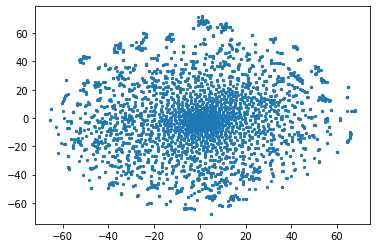

In [62]:
# Now: try tSNE

tsne = TSNE(n_components=2, random_state=24, perplexity=25)
tsne_2d = tsne.fit_transform(df_embeds)

plt.scatter(tsne_2d[:,0], tsne_2d[:,1], s=5)
plt.show()

Playing around with ConceptNet and WordNet
---

In [63]:
# An example with ConceptNet, where I'm searching for the relations of the form UsedFor, between English concepts
# Limit should be set to 1000 (or less); anything more will just return 1000 results
# More information about the API can be found here: https://github.com/commonsense/conceptnet5/wiki/API

obj = requests.get('http://api.conceptnet.io/query?node=/c/en&limit=1000&other=/c/en&rel=/r/UsedFor').json()
edges = [f"{edge['start']['@id']} to {edge['end']['@id']} with rel {edge['rel']['@id']} and weight {edge['weight']}" for edge in obj['edges']]
edges

['/c/en/water to /c/en/drink with rel /r/UsedFor and weight 8.246211251235321',
 '/c/en/pencil to /c/en/write_on_paper with rel /r/UsedFor and weight 7.211102550927979',
 '/c/en/canvas to /c/en/painting_on with rel /r/UsedFor and weight 7.211102550927979',
 '/c/en/gun to /c/en/kill with rel /r/UsedFor and weight 7.211102550927979',
 '/c/en/bank to /c/en/storing_money with rel /r/UsedFor and weight 6.6332495807108',
 '/c/en/bar_stool to /c/en/sitting_on with rel /r/UsedFor and weight 6.6332495807108',
 '/c/en/ocean to /c/en/sailing with rel /r/UsedFor and weight 6.6332495807108',
 '/c/en/kissing to /c/en/expressing_love with rel /r/UsedFor and weight 6.6332495807108',
 '/c/en/dog to /c/en/companionship with rel /r/UsedFor and weight 6.32455532033676',
 '/c/en/going_to_sleep to /c/en/rest with rel /r/UsedFor and weight 6.32455532033676',
 '/c/en/double_edged_razor to /c/en/shaving with rel /r/UsedFor and weight 6.0',
 '/c/en/soap to /c/en/wash_hands with rel /r/UsedFor and weight 6.0',
 

In [64]:
# ConceptNet: searching for edges where one node is body, and the other node is in English

obj = requests.get('http://api.conceptnet.io/query?node=/c/en/body&limit=1000&other=/c/en').json()
edges = [f"{edge['start']['@id']} to {edge['end']['@id']} with rel {edge['rel']['@id']} and weight {edge['weight']}" for edge in obj['edges']]
print(len(edges))
edges

1000


['/c/en/body to /c/en/human with rel /r/RelatedTo and weight 7.75293492814173',
 '/c/en/head to /c/en/body with rel /r/RelatedTo and weight 7.3737371800193685',
 '/c/en/hand to /c/en/body with rel /r/RelatedTo and weight 7.029651484959977',
 '/c/en/eye to /c/en/body with rel /r/RelatedTo and weight 6.9466538707495715',
 '/c/en/leg to /c/en/body with rel /r/RelatedTo and weight 6.437701453158574',
 '/c/en/bone to /c/en/body with rel /r/RelatedTo and weight 6.052767961850181',
 '/c/en/body to /c/en/person with rel /r/RelatedTo and weight 5.1811195701315365',
 '/c/en/blood to /c/en/body with rel /r/RelatedTo and weight 4.843965317794916',
 '/c/en/brain to /c/en/body with rel /r/PartOf and weight 4.47213595499958',
 '/c/en/feet to /c/en/body with rel /r/RelatedTo and weight 4.384062043356595',
 '/c/en/body to /c/en/torso with rel /r/RelatedTo and weight 4.328510136294012',
 '/c/en/ear to /c/en/body with rel /r/RelatedTo and weight 4.3095243357010995',
 '/c/en/neck to /c/en/body with rel /r

In [65]:
# Now use Wordnet: API at https://www.nltk.org/howto/wordnet.html
# Find the parts of "body" (naively)

wn.synset('body.n.01').part_meronyms()

[Synset('arm.n.01'),
 Synset('articulatory_system.n.01'),
 Synset('body_substance.n.01'),
 Synset('cavity.n.04'),
 Synset('circulatory_system.n.01'),
 Synset('crotch.n.02'),
 Synset('digestive_system.n.01'),
 Synset('endocrine_system.n.01'),
 Synset('head.n.01'),
 Synset('leg.n.01'),
 Synset('lymphatic_system.n.01'),
 Synset('musculoskeletal_system.n.01'),
 Synset('neck.n.01'),
 Synset('nervous_system.n.01'),
 Synset('pressure_point.n.01'),
 Synset('respiratory_system.n.01'),
 Synset('sensory_system.n.02'),
 Synset('torso.n.01'),
 Synset('vascular_system.n.01')]

In [66]:
# Traversing down the Wordnet tree (starting from body) through the meronyms relation

(wn.synset('body.n.01').mst(lambda s:s.part_meronyms()))

[Synset('body.n.01'),
 [Synset('arm.n.01'),
  [Synset('arm_bone.n.01')],
  [Synset('biceps_brachii.n.01')],
  [Synset('brachial_artery.n.01')],
  [Synset('cephalic_vein.n.01')],
  [Synset('elbow.n.01'),
   [Synset('funny_bone.n.01')],
   [Synset('musculus_articularis_cubiti.n.01')]],
  [Synset('forearm.n.01'),
   [Synset('accessory_cephalic_vein.n.01')],
   [Synset('anconeous_muscle.n.01')],
   [Synset('basilic_vein.n.01')],
   [Synset('radial_vein.n.01')],
   [Synset('radius.n.04')],
   [Synset('ulna.n.01'), [Synset('olecranon.n.01')]],
   [Synset('ulnar_vein.n.01')]],
  [Synset('hand.n.01'),
   [Synset('ball.n.10')],
   [Synset('digital_arteries.n.01')],
   [Synset('finger.n.01'),
    [Synset('fingernail.n.01')],
    [Synset('fingertip.n.01')],
    [Synset('knuckle.n.01')],
    [Synset('pad.n.07')]],
   [Synset('intercapitular_vein.n.01')],
   [Synset('metacarpal_artery.n.01')],
   [Synset('metacarpal_vein.n.01')],
   [Synset('metacarpus.n.01'), [Synset('metacarpal.n.01')]],
   [Syns

In [67]:
# Another way to get list of body parts: using hyponyms

wn.synset('body_part.n.01').hyponyms()

[Synset('abdomen.n.01'),
 Synset('adnexa.n.01'),
 Synset('ambulacrum.n.01'),
 Synset('ampulla.n.01'),
 Synset('apparatus.n.02'),
 Synset('area.n.03'),
 Synset('back.n.01'),
 Synset('buttock.n.01'),
 Synset('buttocks.n.01'),
 Synset('cannon.n.05'),
 Synset('dilator.n.01'),
 Synset('dock.n.06'),
 Synset('dorsum.n.02'),
 Synset('energid.n.01'),
 Synset('external_body_part.n.01'),
 Synset('feature.n.02'),
 Synset('flank.n.04'),
 Synset('fornix.n.01'),
 Synset('gaskin.n.01'),
 Synset('groove.n.03'),
 Synset('haunch.n.01'),
 Synset('hindquarters.n.02'),
 Synset('hip.n.01'),
 Synset('horseback.n.01'),
 Synset('joint.n.01'),
 Synset('lobe.n.01'),
 Synset('loin.n.02'),
 Synset('loins.n.02'),
 Synset('mentum.n.03'),
 Synset('organ.n.01'),
 Synset('partition.n.03'),
 Synset('process.n.05'),
 Synset('rectum.n.01'),
 Synset('rudiment.n.02'),
 Synset('saddle.n.06'),
 Synset('shank.n.02'),
 Synset('shin.n.01'),
 Synset('shoulder.n.01'),
 Synset('small.n.01'),
 Synset('structure.n.04'),
 Synset('stump

Visualize the ConceptNet pairs in the PCA embedding

Looked through relation HasProperty, found 1000 results
Looked through relation CausesDesire, found 1000 results
Looked through relation MadeOf, found 545 results
Looked through relation IsA, found 1000 results
Looked through relation HasFirstSubevent, found 1000 results
Looked through relation CapableOf, found 1000 results
Looked through relation CreatedBy, found 263 results
Looked through relation EtymologicallyDerivedFrom, found 71 results
Looked through relation HasPrerequisite, found 1000 results
Looked through relation AtLocation, found 1000 results
Looked through relation Causes, found 1000 results
Looked through relation UsedFor, found 1000 results
Looked through relation MotivatedByGoal, found 1000 results
Looked through relation PartOf, found 1000 results
Looked through relation HasA, found 1000 results
Looked through relation HasSubevent, found 1000 results
Looked through relation FormOf, found 1000 results
Looked through relation MannerOf, found 1000 results
Looked through 

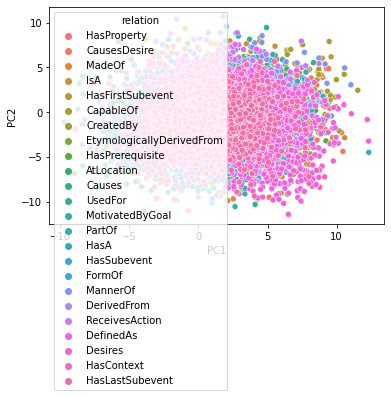

In [68]:
# List of one-directional ConceptNet relations
relations = {'FormOf', 'IsA', 'PartOf', 'HasA', 'UsedFor', 'CapableOf', 'AtLocation', 
             'Causes', 'HasSubevent', 'HasFirstSubevent', 'HasLastSubevent', 'HasPrerequisite',
             'HasProperty', 'MotivatedByGoal', 'ObstructedBy', 'Desires', 'CreatedBy',
             'DerivedFrom', 'DefinedAs', 'MannerOf', 'HasContext',
             'EtymologicallyDerivedFrom', 'CausesDesire', 'MadeOf', 'ReceivesAction'}

relations_pc_df = pd.DataFrame(columns=['PC' + str(i) for i in range(1, num_comps+1)].append('relation'))
relations_by_type = {}

# Get the top 1000 relations for each relation type
for relation in relations:
  obj = requests.get(f'http://api.conceptnet.io/query?limit=1000&node=/c/en&other=/c/en&rel=/r/{relation}').json()

  rel_pairs = []
  for edge in obj['edges']:
    rel_pairs.append((edge['start']['@id'].split('/')[3], edge['end']['@id'].split('/')[3]))
  if rel_pairs == []:
    continue

  # process the senses
  rel_pairs = [(' '.join(s.split('_')), ' '.join(t.split('_'))) for s, t in rel_pairs]
  relations_by_type[relation] = rel_pairs
  rel_senses = set()
  for s, t in rel_pairs:
    rel_senses.add(s)
    rel_senses.add(t)
  rel_senses = list(rel_senses)

  # embed the senses
  embeddings = model.encode(rel_senses)
  rel_embed_dict = {}
  for s, embedding in zip(rel_senses, embeddings):
    rel_embed_dict[s] = embedding

  sources_dict = {i : [rel_embed_dict[s][i] for s, e in rel_pairs] for i in range(embed_length)} 
  targets_dict = {i : [rel_embed_dict[e][i] for s, e in rel_pairs] for i in range(embed_length)} 
  sources_df = pd.DataFrame.from_dict(sources_dict)
  targets_df = pd.DataFrame.from_dict(targets_dict)
  pairs_dif_df = targets_df - sources_df

  # pairs_embeds = pd.concat([ sources_df, targets_df, pairs_dif_df ], axis=1)
  pairs_embeds = pairs_dif_df

  pairs_pc = pca.transform(pairs_embeds)
  pairs_pc_df = pd.DataFrame(data = pairs_pc, 
                            columns = ['PC' + str(i) for i in range(1, num_comps+1)])

  pairs_pc_df['relation'] = relation
  relations_pc_df = pd.concat([relations_pc_df, pairs_pc_df], axis=0)
  print(f'Looked through relation {relation}, found {len(rel_pairs)} results')

sns.scatterplot(x="PC1", y="PC2", data=relations_pc_df, hue="relation")

In [69]:
# Check the number of relations obtained

relations_pc_df.groupby("relation").size()

relation
AtLocation                   1000
CapableOf                    1000
Causes                       1000
CausesDesire                 1000
CreatedBy                     263
DefinedAs                    1000
DerivedFrom                  1000
Desires                      1000
EtymologicallyDerivedFrom      71
FormOf                       1000
HasA                         1000
HasContext                   1000
HasFirstSubevent             1000
HasLastSubevent              1000
HasPrerequisite              1000
HasProperty                  1000
HasSubevent                  1000
IsA                          1000
MadeOf                        545
MannerOf                     1000
MotivatedByGoal              1000
PartOf                       1000
ReceivesAction               1000
UsedFor                      1000
dtype: int64

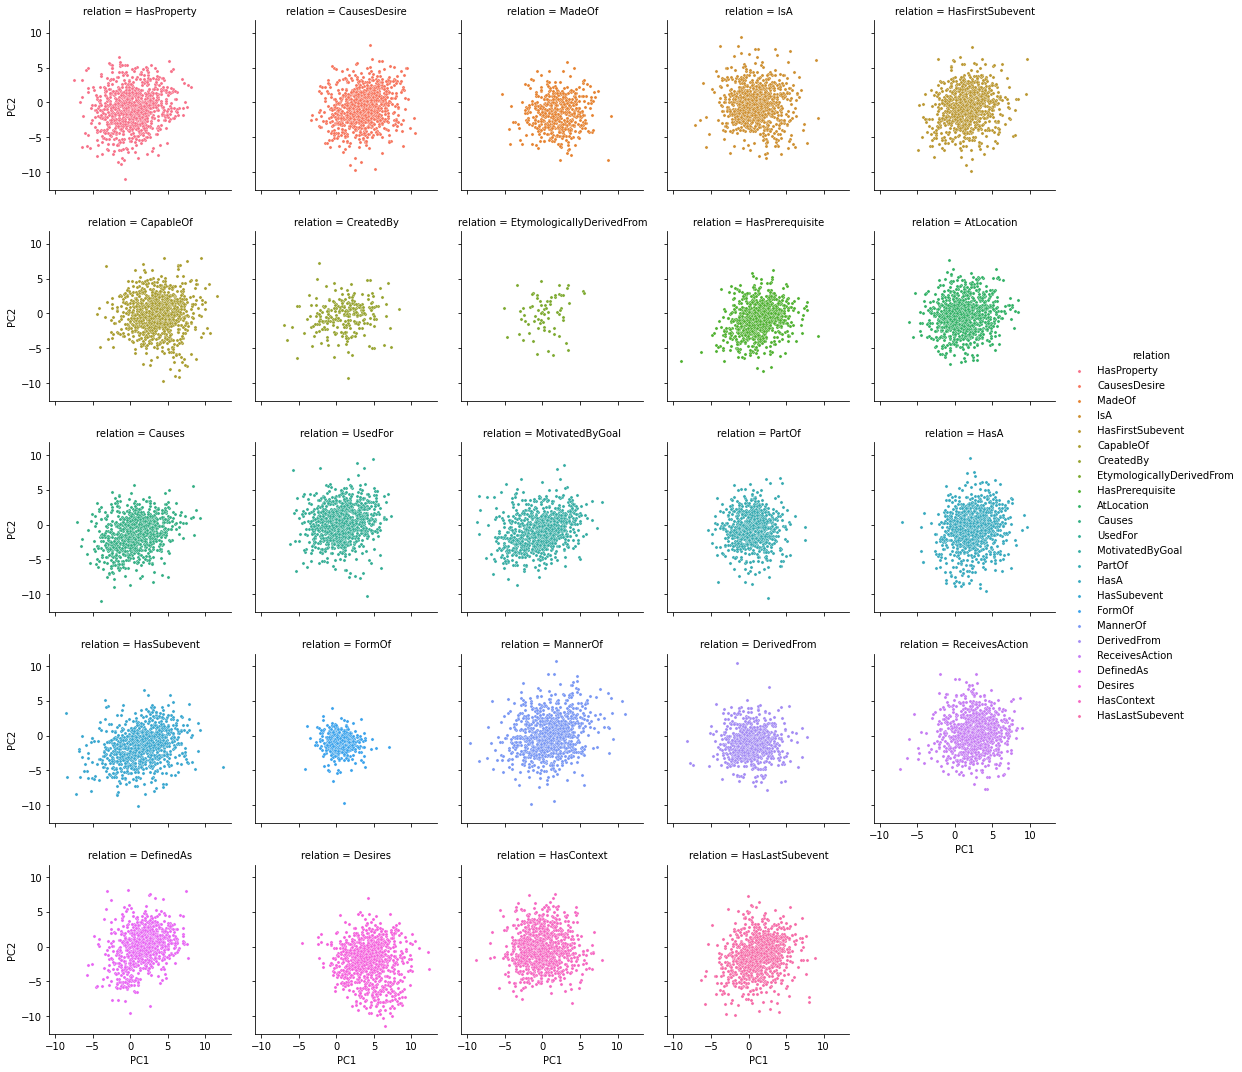

In [70]:
# Plot each relation type in the PCA axes

grid = sns.FacetGrid(relations_pc_df, col = "relation", hue = "relation", col_wrap=5)
grid.map(sns.scatterplot, "PC1", "PC2", s=10)

grid.add_legend()

In [71]:
# Get the top relations of that type

relations_by_type['HasLastSubevent']

[('bathe', 'dry off'),
 ('take shower', 'dry off'),
 ('do exercises', 'do cool down'),
 ('clean clothes', 'put away'),
 ('watch tv', 'turn tv off'),
 ('live', 'die'),
 ('drink', 'swallow'),
 ('leave house', 'lock door'),
 ('go somewhere', 'arrive there'),
 ('bring home fish', 'eat'),
 ('have shower', 'dry'),
 ('urinate', 'flush toilet'),
 ('write', 'put down pen'),
 ('watch evening news', 'turn off tv'),
 ('talk to', 'say goodbye'),
 ('listen to radio', 'turning off radio'),
 ('light match', 'blow out'),
 ('drive car', 'turn off engine'),
 ('eat', 'swallow food'),
 ('itch', 'scratch'),
 ('strike match', 'blow out'),
 ('take bath', 'dry yourself off'),
 ('apply for job', 'interview'),
 ('perform', 'bow'),
 ('swim', 'dry off'),
 ('socialize', 'say goodbye'),
 ('wash car', 'dry car'),
 ('buy', 'pay for'),
 ('hear music', 'turn off radio'),
 ('pass class', 'celebrate'),
 ('clean', 'take out trash'),
 ('mail letter', 'put letter in mailbox'),
 ('listen to radio', 'turn radio off'),
 ('play 

Categorizing principal components based on ontological properties
---

Use Wordnet to find a list of body parts/colors. Then, for every principal component, count the number of shifts in the top/bottom 100 shifts of that principal component that include a source or target that is a body part/color.

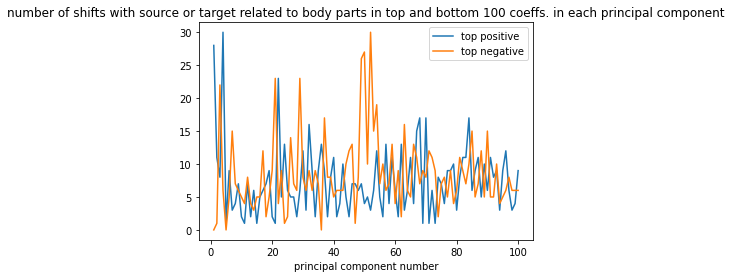

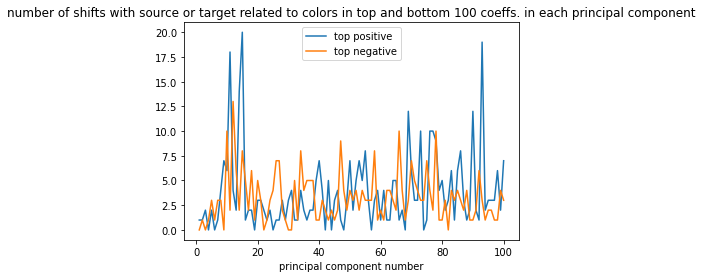

In [72]:
# helper function
def flatten(x):
  if type(x) is list:
    return [a for i in x for a in flatten(i)]
  else:
    return [x]

# Get the list of concepts that are body parts
body_parts = set(map(lambda s: ' '.join(s.split('_')), flatten([s.lemma_names('eng') for s in flatten(wn.synset('body.n.01').mst(lambda s:s.part_meronyms()))])))
colors = set(map(lambda s: ' '.join(s.split('_')), flatten([s.lemma_names('eng') for s in flatten(wn.synset('color.n.01').mst(lambda s:s.hyponyms()))])))

# Given i: find the number of shifts related to [objects] within the top [top_num] shifts (or bottom if descending)
def sum_pc(i, top_num, objects, descending=True):
  sorted_indices = list(principal_df.sort_values(by=f'PC{i}', ascending=(not descending)).index)[:top_num]
  counter = 0

  for index in sorted_indices: 
    if meaning_pairs[index][0] in objects or meaning_pairs[index][1] in objects:
      counter += 1

  return counter

x = range(1, num_comps+1)

plt.title('number of shifts with source or target related to body parts in top and bottom 100 coeffs. in each principal component')
plt.xlabel('principal component number')
plt.plot(x, [sum_pc(i, 100, body_parts, True) for i in x], label="top positive")
plt.plot(x, [sum_pc(i, 100, body_parts, False) for i in x], label="top negative")
plt.legend()
plt.show()

plt.title('number of shifts with source or target related to colors in top and bottom 100 coeffs. in each principal component')
plt.xlabel('principal component number')
plt.plot(x, [sum_pc(i, 100, colors, True) for i in x], label="top positive")
plt.plot(x, [sum_pc(i, 100, colors, False) for i in x], label="top negative")
plt.legend()
plt.show()

Same thing for ConceptNet, but more general!

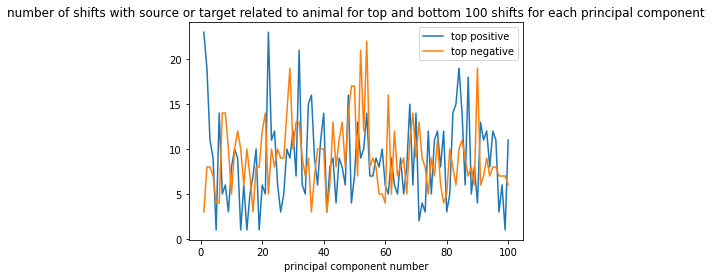

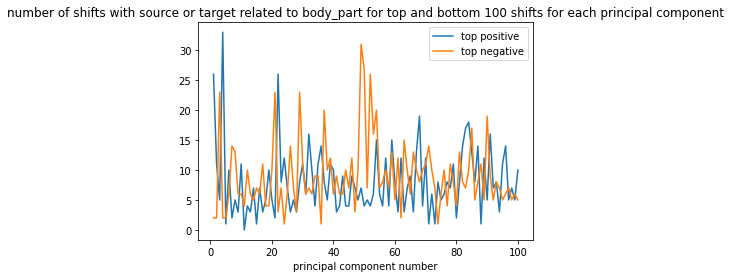

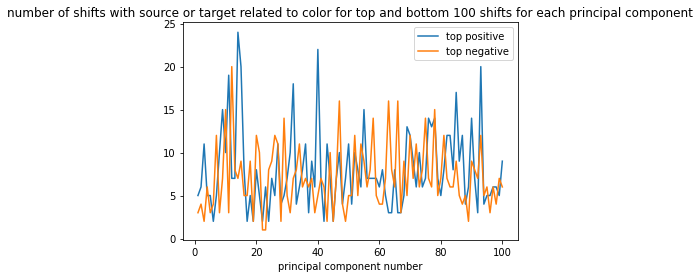

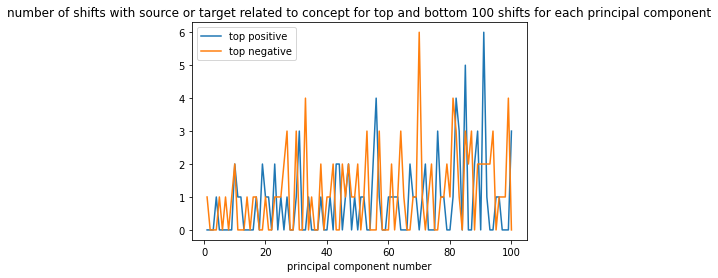

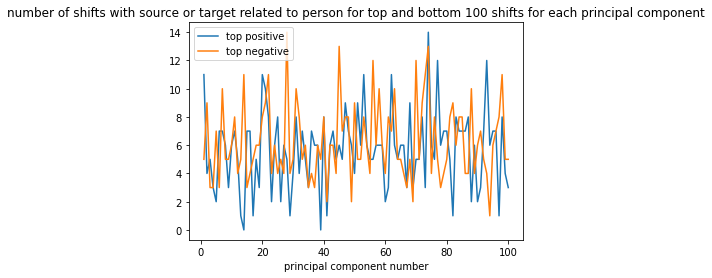

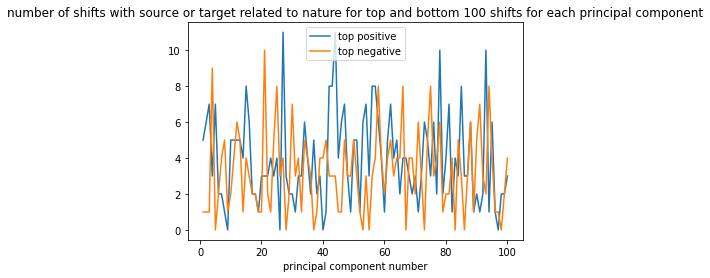

In [73]:
# Given i: find the number of shifts related to [objects] within the top [top_num] shifts (or bottom if descending)
def related_shifts_count(i, top_num, concept, descending=True):
  obj = requests.get(f'http://api.conceptnet.io/query?node=/c/en/{concept}&limit=1000&other=/c/en').json()
  objects = set()
  for edge in obj['edges']:
    objects.add(' '.join(edge['start']['@id'].split('/')[3].split('_')))
    objects.add(' '.join(edge['end']['@id'].split('/')[3].split('_')))

  sorted_indices = list(principal_df.sort_values(by=f'PC{i}', ascending=(not descending)).index)[:top_num]
  counter = 0

  for index in sorted_indices: 
    if meaning_pairs[index][0] in objects or meaning_pairs[index][1] in objects:
      counter += 1

  return counter

def graph_related_shifts(concept):
  plt.title(f'number of shifts with source or target related to {concept} for top and bottom 100 shifts for each principal component')
  plt.xlabel('principal component number')
  plt.plot(x, [related_shifts_count(i, 100, concept, True) for i in x], label="top positive")
  plt.plot(x, [related_shifts_count(i, 100, concept, False) for i in x], label="top negative")
  plt.legend()
  plt.show()

graph_related_shifts("animal")
graph_related_shifts("body_part")
graph_related_shifts("color")
graph_related_shifts("concept")
graph_related_shifts("person")
graph_related_shifts("nature")